# Imports

In [1]:
# !pip install -q wurlitzer
# !pip install -q --upgrade keras-cv tensorflow
# !pip install -q --upgrade keras

In [2]:
import os
from tqdm import tqdm 

import tensorflow as tf
import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

print('running tf: ', tf.__version__)
print('running keras: ', tf.__version__)

2024-06-25 12:07:50.193378: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-25 12:07:50.193511: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-25 12:07:50.310426: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


running tf:  2.15.0
running keras:  2.15.0


In [3]:
# os.environ["KERAS_BACKEND"] = "tensorflow"  # Or "jax" or "torch"!

# Config

In [4]:
DEBUG = False
input_size = 224
# num_frames = 1
batch_size = 16 
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Data Loading

In [5]:
def data_augment(image, label=None, seed=123):

#     image = transform(image, IMG_SIZES[0])
    #image = tf.image.rot90(image,k=np.random.randint(4)) # rotate
    image = tf.image.random_flip_left_right(image, seed=seed) # flip horizontal
#     image = tf.image.random_flip_up_down(image, seed=seed) # flip vertical
    image = tf.image.random_brightness(image, max_delta=0.2) # random brightness
    image = tf.image.random_contrast(image, 0.8, 1.2) # random contrast
    image = tf.image.random_saturation(image, 0.7, 1.3) # random saturation
    
    if label is None:
        return image
    else:
        return image, label

In [6]:
def read_frames_from_folder(folder_path):
    folder_path = folder_path.numpy().decode('utf-8')
    # Get list of all frame files
    frame_files = sorted([os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.jpg')])
    
    frames = []
    for frame_file in frame_files[-3:]:
        img = image.load_img(frame_file, target_size=(input_size, input_size), interpolation='bicubic',keep_aspect_ratio=True)
        img_array = image.img_to_array(img)
        frames.append(img_array)
    
    frames = tf.convert_to_tensor(frames, dtype=tf.float32)
    return frames

def load_frames_from_folder(file_path, label = None):
    frames = tf.py_function(func=read_frames_from_folder, inp=[file_path], Tout=tf.float32)
    frames.set_shape([None, input_size, input_size, 3])
    
    if label is None:
        return frames
    
    labels = tf.repeat(tf.cast(label, dtype=tf.float32), tf.shape(frames)[0])
    labels = tf.convert_to_tensor(labels, dtype=tf.float32)
    return frames, labels

def create_dataset(file_paths, labels, shuffle_buffer_size=None):
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    
    # Shuffle training data
    if shuffle_buffer_size:
        dataset = dataset.shuffle(buffer_size=shuffle_buffer_size)
    
    dataset = dataset.map(load_frames_from_folder, num_parallel_calls=AUTOTUNE)
    dataset = dataset.flat_map(lambda frames, labels: tf.data.Dataset.from_tensor_slices((frames, labels)))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset


In [7]:
# def read_last_frame_from_folder(folder_path):
#     folder_path = folder_path.numpy().decode('utf-8')
#     # Get list of all frame files
#     frame_files = sorted([os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.jpg')])
    
#     # Take the last frame file
#     last_frame_file = frame_files[-1] if frame_files else None
    
#     if last_frame_file:
#         img = image.load_img(last_frame_file, target_size=(input_size, input_size), interpolation='bicubic',keep_aspect_ratio=True)
#         img_array = image.img_to_array(img)
#         img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
#     else:
#         # Handle the case where the folder is empty
#         img_tensor = tf.zeros((input_size, input_size, 3), dtype=tf.float32)
    
#     return img_tensor

# def load_last_frame_from_folder(file_path, label=None):
#     image_tensor = tf.py_function(func=read_last_frame_from_folder, inp=[file_path], Tout=tf.float32)
#     image_tensor.set_shape([input_size, input_size, 3])
#     if label is None:
#         return image_tensor
#     return image_tensor, tf.cast(label, dtype=tf.float32)

# def create_dataset(file_paths, labels, shuffle_buffer_size=None):
#     dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    
#     # shuffle training data
#     if shuffle_buffer_size:
#         dataset = dataset.shuffle(buffer_size=shuffle_buffer_size)
    
#     dataset = dataset.map(load_last_frame_from_folder, num_parallel_calls=AUTOTUNE)
#     dataset = dataset.map(data_augment, num_parallel_calls=AUTOTUNE)
#     dataset = dataset.batch(batch_size)
#     dataset = dataset.prefetch(AUTOTUNE)
#     return dataset

In [8]:
# Paths to your data
freeway_train_path = '/kaggle/input/2nd-ava-challenge-ieee-mipr-2024/2nd_AVA_Dataset_2ed/freeway/train'
road_train_path = '/kaggle/input/2nd-ava-challenge-ieee-mipr-2024/2nd_AVA_Dataset_2ed/road/train'
freeway_train_csv = '/kaggle/input/2nd-ava-challenge-ieee-mipr-2024/2nd_AVA_Dataset_2ed/freeway_train.csv'
road_train_csv = '/kaggle/input/2nd-ava-challenge-ieee-mipr-2024/2nd_AVA_Dataset_2ed/road_train.csv'

# Read CSV files
freeway_df = pd.read_csv(freeway_train_csv)
road_df = pd.read_csv(road_train_csv)

# Add the directory path to the file names
freeway_df['file_name'] = freeway_df['file_name'].apply(lambda x: os.path.join(freeway_train_path, x))
road_df['file_name'] = road_df['file_name'].apply(lambda x: os.path.join(road_train_path, x))

# Combine dataframes
all_df = pd.concat([freeway_df, road_df])

if DEBUG:
    all_df = all_df[:20]

In [9]:
# Split into train and validation sets
train_df, val_df = train_test_split(all_df, test_size=0.1, random_state=42, stratify=all_df['risk'])

# Create datasets
train_dataset = create_dataset(train_df['file_name'].values, train_df['risk'].values, shuffle_buffer_size=len(train_df))
val_dataset = create_dataset(val_df['file_name'].values, val_df['risk'].values)

### Sanity Check

In [10]:
# print('Got train data: ', len(train_df), len(train_dataset))
# print('Got val data:', len(val_df), len(val_dataset))

In [11]:
# Example: Iterate through the train dataset
for videos, labels in train_dataset.take(1):
    print(videos.shape, labels.shape)

# Example: Iterate through the validation dataset
for videos, labels in val_dataset.take(1):
    print(videos.shape, labels.shape)

(16, 224, 224, 3) (16,)
(16, 224, 224, 3) (16,)


### Plot the Data

In [12]:
# import matplotlib.pyplot as plt
# import numpy as np

# def plot_sample_frames(dataset, num_samples=3, frames_to_plot=5):
#     """
#     Plots a few frames of sample videos from the dataset along with their labels.

#     Args:
#     dataset: tf.data.Dataset - The dataset containing video frames and labels.
#     num_samples: int - Number of sample videos to plot.
#     frames_to_plot: int - Number of frames to plot from each sample video.
#     """
#     # Take num_samples from the dataset
#     for videos, labels in dataset.take(num_samples):
#         # Convert tensors to numpy arrays
#         videos = videos.numpy()
#         labels = labels.numpy()
        
#         # Iterate over each sample in the batch
#         for i in range(videos.shape[0]):
#             fig, axes = plt.subplots(1, frames_to_plot, figsize=(15, 5))
#             fig.suptitle(f'Sample {i+1} - Label: {int(labels[i])}', fontsize=16)
            
#             # Plot a few frames from the sample video
#             for j in range(frames_to_plot):
#                 if j < videos.shape[1]:
#                     frame = videos[i, j]
#                     axes[j].imshow(frame.astype(np.uint8))
#                     axes[j].axis('off')
            
#             plt.show()

# # Example usage:
# # Plot a few frames of 2 sample videos from the train dataset
# plot_sample_frames(train_dataset, num_samples=2, frames_to_plot=5)

# Model

In [13]:
# !pip install -q image-classifiers # library doesn't seem to work w/ newer tf versions

In [14]:
# from classification_models.tfkeras import Classifiers

# SeResNeXT, preprocess_fn = Classifiers.get('seresnext50')

In [15]:
feature_extractor = tf.keras.applications.EfficientNetV2M(
    weights='imagenet', 
    include_top=False,  
    input_shape=(input_size, input_size, 3), 
    pooling=None,
)

# feature_extractor = SeResNeXT(input_shape=(224,224,3), weights='imagenet', include_top=False)
# preprocess_layer = tf.keras.layers.Lambda(lambda x: preprocess_fn(x))


model = tf.keras.models.Sequential([
    tf.keras.Input((input_size, input_size, 3)),
#     preprocess_layer,
    feature_extractor,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(512, activation= 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(rate= 0.25, seed= 123),
    tf.keras.layers.Dense(2, activation=None)
])

214201816/214201816 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step


In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-m (Functional)   │ (None, 7, 7, 1280)     │    53,150,388 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,812,406 (205.28 MB)

 Trainable params: 53,517,814 (204.15 MB)

 Non-trainable params: 294,592 (1.12 MB)

## Optimize & Compile

In [17]:
def lrfn(epoch):
    if epoch < lr_ramp_ep:
        lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start

    elif epoch < lr_ramp_ep + lr_sus_ep:
        lr = lr_max

    else:
        lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min

    return lr

def get_lr_callback(batch_size=16):
#     lr_start   = 0.000005
#     lr_max     = 0.000003 * batch_size
#     lr_min     = 0.000001
#     lr_ramp_ep = 5
#     lr_sus_ep  = 0
#     lr_decay   = 0.3
       
    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

Learning rate schedule: 0.0005 to 0.032 to 0.000305


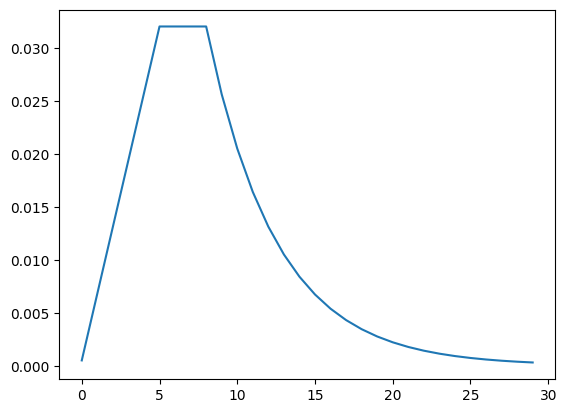

In [18]:
EPOCHS = 10 if DEBUG else 30
lr_start   = 0.0005
lr_max     = 0.002 * batch_size
lr_min     = 0.00001
lr_ramp_ep = 5
lr_sus_ep  = 3
lr_decay   = 0.8

rng = [i for i in range(8 if EPOCHS<8 else EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [19]:
# ModelCheckpoint callback - to save best model from every training
checkpoint = keras.callbacks.ModelCheckpoint("best_model.weights.h5", 
                                                save_best_only=True, 
                                                save_weights_only=True,
                                                verbose=0,
                                                monitor='val_loss', 
                                                mode='min')

csv_logger = tf.keras.callbacks.CSVLogger('history.csv')

learning_rate_reduction= keras.callbacks.ReduceLROnPlateau(monitor='loss',patience=2,verbose=1,factor=0.1,min_lr=0.0000000001) 

# callbacks = [checkpoint, learning_rate_reduction]

callbacks = [checkpoint, csv_logger, get_lr_callback()]

In [20]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(nesterov=False),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
    ],
)

## Train Model

In [21]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
#     steps_per_epoch=len(train_df) // batch_size,
#     validation_steps=len(test_df) // batch_size,
    epochs=EPOCHS,
    callbacks=callbacks,
)

Epoch 1/30


I0000 00:00:1719317504.452001      69 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


      1/Unknown 198s 198s/step - accuracy: 0.6250 - loss: 8.0994

W0000 00:00:1719317504.695547      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


     61/Unknown 449s 4s/step - accuracy: 0.5169 - loss: 8.2405

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
W0000 00:00:1719317775.337783      66 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


61/61 ━━━━━━━━━━━━━━━━━━━━ 488s 5s/step - accuracy: 0.5176 - loss: 8.2393 - val_accuracy: 0.6759 - val_loss: 7.9359 - learning_rate: 5.0000e-04
Epoch 2/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.6854 - loss: 7.9835 - val_accuracy: 0.7685 - val_loss: 7.7838 - learning_rate: 0.0068
Epoch 3/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.7676 - loss: 7.6969 - val_accuracy: 0.6852 - val_loss: 7.5825 - learning_rate: 0.0131
Epoch 4/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.8106 - loss: 7.3556 - val_accuracy: 0.6296 - val_loss: 7.5579 - learning_rate: 0.0194
Epoch 5/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.8487 - loss: 6.9331 - val_accuracy: 0.6481 - val_loss: 7.0455 - learning_rate: 0.0257
Epoch 6/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.8368 - loss: 6.6085 - val_accuracy: 0.6667 - val_loss: 7.2236 - learning_rate: 0.0320
Epoch 7/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.8979 - loss: 5.9169 - val_accuracy: 

In [22]:
model.save('zero-model.keras')

In [23]:
model.load_weights('/kaggle/working/best_model.weights.h5')

## Plots

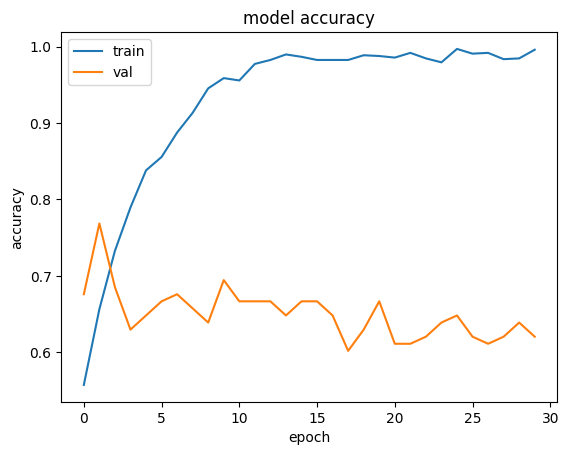

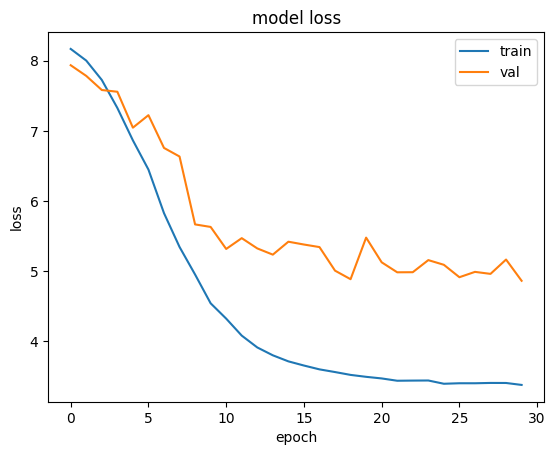

In [24]:
plt.figure(1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.figure(2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

# Inference

In [25]:
# Softmax function to convert logits to probabilities
def softmax(logits):
    exp_logits = np.exp(logits)
    return exp_logits / np.sum(exp_logits, axis=-1, keepdims=True)

In [26]:
def run_inference_on_video(video_path, model):
    frames = load_frames_from_folder(video_path)
    frames = tf.data.Dataset.from_tensor_slices(frames).batch(batch_size).prefetch(AUTOTUNE)
    
    predictions = []
    for frame_batch in frames:
        preds = model.predict(frame_batch, verbose=0)
        predictions.extend(preds)
    
    return predictions

def aggregate_predictions(predictions):
    avg_prediction = sum(predictions) / len(predictions)
    return avg_prediction


def process_videos_multiple_frames(file_paths, model):
    results = {}
    for file_path in tqdm(file_paths):
        video_name = os.path.basename(file_path)
        predictions = run_inference_on_video(file_path, model)
#         print('preds', predictions)
        probabilities = [softmax(pred) for pred in predictions]
#         print('probabilities', probabilities)
        positive_probs = [prob[1] for prob in probabilities]
#         print('pos', positive_probs)
        agg_preds = aggregate_predictions(positive_probs)
#         print('agg', agg_preds)
        results[video_name] = agg_preds
    return results

In [27]:
# def run_inference_on_last_frame(video_path, model):
#     frame = load_last_frame_from_folder(video_path)
#     frame = tf.expand_dims(frame, axis=0)  # Add batch dimension
    
#     prediction = model.predict(frame, verbose=0)
#     return prediction[0]  # Return the prediction for the single frame

# def process_videos(file_paths, model):
#     results = {}
#     for file_path in tqdm(file_paths):
#         video_name = os.path.basename(file_path)
#         predictions = run_inference_on_last_frame(file_path, model)
# #         print('preds', predictions)
#         probabilities = softmax(predictions)
# #         print('probabilities', probabilities)
#         positive_probs = probabilities[1]
# #         print('pos', positive_probs)
#         results[video_name] = positive_probs
#     return results


In [28]:
# Load the sample submission file
submission_df = pd.read_csv('/kaggle/input/2nd-ava-challenge-ieee-mipr-2024/2nd_AVA_Dataset_2ed/sample_submission.csv')

if DEBUG:
    submission_df = submission_df[:5]

# Get test file names
test_files = submission_df['file_name'].values

# Paths to test data
freeway_test_path = '/kaggle/input/2nd-ava-challenge-ieee-mipr-2024/2nd_AVA_Dataset_2ed/freeway/test'
road_test_path = '/kaggle/input/2nd-ava-challenge-ieee-mipr-2024/2nd_AVA_Dataset_2ed/road/test'

# Create list of file paths
test_file_paths = []
for file_name in test_files:
    if 'road' in file_name:
        test_file_paths.append(os.path.join(road_test_path, file_name))
    elif 'freeway' in file_name:
        test_file_paths.append(os.path.join(freeway_test_path, file_name))

# Run inference and aggregate predictions
results = process_videos_multiple_frames(test_file_paths, model)

# Create submission dataframe
submission_df['risk'] = submission_df['file_name'].apply(lambda x: results[x])
submission_df.to_csv('submission.csv', index=False)

100%|██████████| 243/243 [02:24<00:00,  1.68it/s]
